In [6]:
from operator import itemgetter # getting max q from a dict
import random
import numpy
import matplotlib.pyplot as plt

In [147]:
class mdp():
    def __init__(self, error_prob):

        self.actions = ["top",
                        "left",
                        "right",
                        "bottom"]

        self.q = {}

        self.state = {}
        
        # RL parameters.
        self.alpha = 0.1 # learning rate
        self.epsilon = 0.5 # explore vs exploit
        self.gamma = 0.9 # future reward discount 
        self.error_prob = error_prob

        # Initialise the environment.
        self.reset()
        
    def set_error_prob(self, error_prob):
        self.error_prob = error_prob
        
    def reset(self):

        self.state = {
            "task": "start",
            "position": "s1"}

        # Start with no previous state, no current state, no previous
        # action, and no current action.
        self.previous_state = None
        self.current_state = None
        self.previous_action = None
        self.action = None
        
    def update_environment(self):

        position = self.state["position"]
        if position == "s2":
            # with a prob entering the error state
            if random.random() < self.error_prob:
                self.state["position"] = "e1"
            else:
                if self.action == "left": 
                    self.state["position"] = "s1"
                elif self.action == "right":
                    self.state["position"] = "s3"
        else:
            if self.action == "left":        
                if position == "s3":
                    self.state["position"] = "s2"
                if position == "s4":
                    self.state["position"] = "s3"
                if position == "e3":
                    self.state["position"] = "e2"
                if position == "e4":
                    self.state["position"] = "e3"
            if self.action == "right":
                if position == "s1":
                    self.state["position"] = "s2"
                if position == "s3":
                    self.state["position"] = "s4"
                if position == "e2":
                    self.state["position"] = "e3"
                if position == "e3":
                    self.state["position"] = "e4"
                if position == "s4":
                    self.state["task"] = "done"
            if self.action == "top":
                if position == "e2":
                    self.state["position"] = "e1"
                if position == "e3":
                    self.state["position"] = "e6"
                if position == "e4":
                    self.state["position"] = "e5"
                if position == "e6":
                    self.state["position"] = "s3"
            if self.action == "bottom":
                if position == "e1":
                    self.state["position"] = "e2"
                if position == "e6":
                    self.state["position"] = "e3"
                if position == "e5":
                    self.state["position"] = "e4"

    def calculate_reward(self):
        self.reward = 0
        position = self.state["position"]
        action = self.action
#         if action == "left" and (position == "s1" or position == "s2" or position == "s3" or position == "e2" or position == "e3"):
#             self.reward += -2
#         if action == "right" and (position == "s2" or position == "s3" or position == "e3"):
#             self.reward += -1
#         if action == "bottom" and (position == "e1"):
#             self.reward += -3
#         if action == "bottom" and (position == "e2" or position == "e4"):
#             self.reward += -2
        self.reward += -1
        if self.state["task"] == "done":
            self.reward += 20
            
    def choose_action_epsilon_greedy(self):
        if random.random() < self.epsilon:
            self.action = random.choice(self.actions)
            return "randomly" # for output (debug) purposes
        else:
            self.action = max(self.q[self.current_state].items(), key = itemgetter(1))[0]
            return "greedily"
        
    def print_state(self):
        print("Current state:")
        for s in self.state:
            print("   ", s, ":", self.state[s])
            print()
            
    def print_q(self, state = None):
        for s in self.q:
            print(s)
            if state == None or repr(state) == s:
                for a in self.actions:
                    print("   ", a, ":", round(self.q[s][a],2))
                    
    def update_q_learning(self):
        # Only learn if there is a previous action. If this is a start
        # of a new episode after a self.reset(), cannot learn yet.
        if self.previous_action != None:
            previous_q = self.q[self.previous_state][self.previous_action]
            next_q = max(self.q[self.current_state].items(), key = itemgetter(1))[1]
            self.q[self.previous_state][self.previous_action] = \
                previous_q + self.alpha * (self.reward + self.gamma * next_q - previous_q)
            
    def update_q_td(self):
        previous_q = self.q[self.current_state][self.action]
        self.q[self.current_state][self.action] = \
                previous_q + self.alpha * (self.reward - previous_q)
    
    def iterate_model(self, print_progress = False, force_action = None, Testing = False):
        self.previous_state = self.current_state
        self.previous_action = self.action

        self.current_state = repr(self.state)
       
        if self.current_state not in self.q:
            self.q[self.current_state] = {}
            # Add all actions as possible pairs if this new state.
            for a in self.actions:
                self.q[self.current_state][a] = 0.0

        self.update_q_learning()

        # Choose action, store the explore or exploit as a string for
        # outputting (debug). If the action is forced, take that action.
        if force_action:
            self.action = force_action
            how = "forced"
        else:
            how = self.choose_action_epsilon_greedy()

        if print_progress: print("Took action <", self.action, "> ", how, sep = '')
        # Based on the action and the current state, update the environment.
        self.update_environment()

        self.calculate_reward()
        if print_progress: print("Reward =", self.reward)

        # If the state is end state, update using TD learning, because
        # Q learning only happens when there is a previous state,
        # which reset removes.
        if self.state["task"] == "done":
            if print_progress:
                print("Task done!")
                self.print_state()
            self.update_q_td()
            # Reset the environment. The Q-table is retained as
            # memory, but the task starts again.
            if not Testing:
                self.reset()

In [204]:
novice_agent = mdp(error_prob=0)
print("Training the model...")
for i in range(0, 100000):
    novice_agent.iterate_model()
print(f'Q-values of novice agent with error_prob=0')
# Print the learned Q-values?
novice_agent.print_q()
# print('#######################')
# novice_agent.set_error_prob(1)
# for i in range(0, 1000):
#     novice_agent.iterate_model()
# print(f'2nd stage of Q-values')
# # Print the learned Q-values?
# agent.print_q()

Training the model...
Q-values of novice agent with error_prob=0
{'task': 'start', 'position': 's1'}
    top : 9.03
    left : 9.03
    right : 11.14
    bottom : 9.03
{'task': 'start', 'position': 's2'}
    top : 11.14
    left : 9.03
    right : 13.49
    bottom : 11.14
{'task': 'start', 'position': 's3'}
    top : 13.49
    left : 11.14
    right : 16.1
    bottom : 13.49
{'task': 'start', 'position': 's4'}
    top : 16.1
    left : 13.49
    right : 19.0
    bottom : 16.1


In [283]:
expert_agent = mdp(error_prob=1)
print("Training the model...")
for i in range(0, 10):
    expert_agent.iterate_model()
print(f'Q-values of expert agent with error_prob=0.5')
# Print the learned Q-values?
expert_agent.print_q()

Training the model...
Q-values of expert agent with error_prob=0.5
{'task': 'start', 'position': 's1'}
    top : -0.19
    left : -0.1
    right : -0.1
    bottom : 0.0
{'task': 'start', 'position': 's2'}
    top : -0.1
    left : 0.0
    right : 0.0
    bottom : 0.0
{'task': 'start', 'position': 'e1'}
    top : -0.1
    left : -0.1
    right : -0.1
    bottom : -0.1
{'task': 'start', 'position': 'e2'}
    top : 0.0
    left : 0.0
    right : 0.0
    bottom : 0.0


In [284]:
# Test novice
novice_agent.set_error_prob(1)
novice_agent.reset()
novice_agent.epsilon = 0
done = False
n_trials = 0

def terminate(state):
    if state["task"] == "done":
        return True
    return False

while done is False:
#     novice_agent.print_state()
#     novice_agent.print_q(novice_agent.state)
    novice_agent.iterate_model(print_progress = True, Testing=True)
    
    n_trials += 1
    done = terminate(novice_agent.state)
    
    if n_trials > 1000:
        done = True
        
print(n_trials)

Took action <right> greedily
Reward = -1
Took action <bottom> greedily
Reward = -1
Took action <bottom> greedily
Reward = -1
Took action <right> greedily
Reward = -1
Took action <top> greedily
Reward = -1
Took action <top> greedily
Reward = -1
Took action <right> greedily
Reward = -1
Took action <right> greedily
Reward = 19
Task done!
Current state:
    task : done

    position : s4

8


In [ ]:
expert_agent = mdp(error_prob=0.5)
print("Training the model...")
for i in range(0, 10000):
    expert_agent.iterate_model()
print(f'Q-values of expert agent with error_prob=0.5')
# Print the learned Q-values?
expert_agent.print_q()

In [285]:
# Test expert
expert_agent.set_error_prob(1)
expert_agent.reset()
expert_agent.epsilon = 0
done = False
n_trials = 0

def terminate(state):
    if state["task"] == "done":
        return True
    return False
expert_agent.print_state()

while done is False:
#     expert_agent.print_state()
#     expert_agent.print_q(expert_agent.state)
    expert_agent.iterate_model(print_progress = True, Testing=True)
    n_trials += 1
    done = terminate(expert_agent.state)
    
    if n_trials > 1000:
        done = True
        
print(n_trials)

Current state:
    task : start

    position : s1

Took action <bottom> greedily
Reward = -1
Took action <left> greedily
Reward = -1
Took action <right> greedily
Reward = -1
Took action <left> greedily
Reward = -1
Took action <top> greedily
Reward = -1
Took action <left> greedily
Reward = -1
Took action <right> greedily
Reward = -1
Took action <bottom> greedily
Reward = -1
Took action <top> greedily
Reward = -1
Took action <bottom> greedily
Reward = -1
Took action <left> greedily
Reward = -1
Took action <right> greedily
Reward = -1
Took action <top> greedily
Reward = -1
Took action <top> greedily
Reward = -1
Took action <top> greedily
Reward = -1
Took action <left> greedily
Reward = -1
Took action <right> greedily
Reward = -1
Took action <top> greedily
Reward = -1
Took action <left> greedily
Reward = -1
Took action <right> greedily
Reward = -1
Took action <bottom> greedily
Reward = -1
Took action <bottom> greedily
Reward = -1
Took action <left> greedily
Reward = -1
Took action <right>

In [328]:
def terminate(state):
    if state["task"] == "done":
        return True
    return False

def test(agent):
    done = False
    n_trials = 0

    while done is False:
        agent.iterate_model(print_progress = False, Testing=True)

        n_trials += 1
        done = terminate(agent.state)

        if n_trials > 1000:
            done = True
            
    return n_trials

# Test novice
novice_agent = mdp(error_prob=0)
print("Training the model...")
for i in range(0, 10000):
    novice_agent.iterate_model()
print(f'Q-values of novice agent with error_prob=0')
# Print the learned Q-values?
novice_agent.print_q()
# Save the q table
tem_q_table = copy.deepcopy(novice_agent.q)

# novice_agent.set_error_prob(1)
# novice_agent.reset()
# done = False
# n_trials = 0
# novice_agent.epsilon = 0

# while done is False:
# #     novice_agent.print_state()
# #     novice_agent.print_q(novice_agent.state)
#     novice_agent.iterate_model(print_progress = False, Testing=True)

#     n_trials += 1
#     done = terminate(novice_agent.state)

#     if n_trials > 1000:
#         done = True
        
# print(n_trials)

# the number of training episodes
n_training = [1]+list(range(50,1000,50))
n_error_prob = [0.1, 0.5, 1]
n_steps = defaultdict(list)

for i in n_training:
    for ep in n_error_prob:
        # training with epsilon = 0.1 and different error_prob
        novice_agent.epsilon = 0.1
        novice_agent.q = copy.deepcopy(tem_q_table)
        novice_agent.set_error_prob(ep)

        for j in range(0, i):
            novice_agent.iterate_model()

        # test
        novice_agent.set_error_prob(1)
        novice_agent.epsilon = 0
        novice_agent.reset()
        n_trials = test(novice_agent)
        n_steps[ep].append(n_trials)

print(n_steps)

Training the model...
Q-values of novice agent with error_prob=0
{'task': 'start', 'position': 's1'}
    top : 9.03
    left : 9.03
    right : 11.14
    bottom : 9.03
{'task': 'start', 'position': 's2'}
    top : 11.14
    left : 9.03
    right : 13.49
    bottom : 11.14
{'task': 'start', 'position': 's3'}
    top : 13.49
    left : 11.14
    right : 16.1
    bottom : 13.49
{'task': 'start', 'position': 's4'}
    top : 16.1
    left : 13.49
    right : 19.0
    bottom : 16.1
defaultdict(<class 'list'>, {0.1: [17, 25, 25, 16, 9, 10, 9, 10, 9, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8], 0.5: [17, 18, 9, 8, 9, 8, 8, 10, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], 1: [17, 16, 8, 10, 12, 14, 11, 11, 11, 12, 10, 9, 9, 9, 8, 8, 8, 8, 8, 8]})


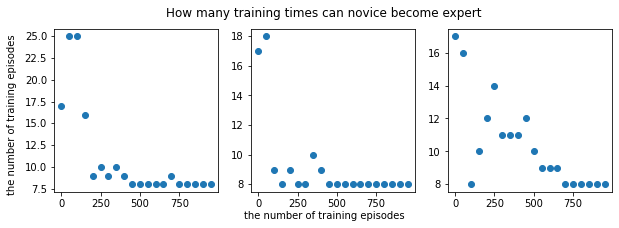

In [375]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.scatter(n_training, n_steps[0.1])
ax2.scatter(n_training, n_steps[0.5])
ax3.scatter(n_training, n_steps[1])

fig.text(0.5, 0, 'the number of training episodes', ha='center')
fig.text(0.06, 0.12, 'the number of training episodes', rotation='vertical')
fig.suptitle('How many training times can novice become expert')
plt.show()


In [234]:
a=[1,20,30]
numpy.cumsum(a)


array([ 1, 21, 51])

In [249]:
[1]+list(range(5,55,5))

[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [240]:
copy.deepcopy(novice_agent.q)

{"{'task': 'start', 'position': 's1'}": {'top': 8.150301334080034,
  'left': 7.948289993249038,
  'right': 10.281898759104017,
  'bottom': 8.080559021335377},
 "{'task': 'start', 'position': 's2'}": {'top': 7.961185131764275,
  'left': 7.310396301600434,
  'right': 11.455306874043059,
  'bottom': 7.903033332709773},
 "{'task': 'start', 'position': 's3'}": {'top': 13.55541288537817,
  'left': 10.304837710010336,
  'right': 16.100100414622258,
  'bottom': 13.521124882039832},
 "{'task': 'start', 'position': 's4'}": {'top': 16.188794905130614,
  'left': 13.529788510726078,
  'right': 19.00001020224953,
  'bottom': 16.13796232138917},
 "{'task': 'start', 'position': 'e1'}": {'top': -0.967296310796197,
  'left': -1.0318868892870319,
  'right': -0.6926803999465068,
  'bottom': 3.948645800494972},
 "{'task': 'start', 'position': 'e2'}": {'top': -0.44955319743910005,
  'left': -0.003797787000318631,
  'right': 7.318026243858537,
  'bottom': -0.5778869932},
 "{'task': 'start', 'position': 'e3'}

In [239]:
from collections import defaultdict
import copy

In [179]:


novice_agent.set_error_prob(1)
novice_agent.reset()
done = False
n_trials = 0

def terminate(state):
    if state["task"] == "done":
        return True
    return False

while done is False:
#     novice_agent.print_state()
#     novice_agent.print_q(novice_agent.state)
    novice_agent.iterate_model(print_progress = False, Testing=True)
    
    n_trials += 1
    done = terminate(novice_agent.state)
    
    if n_trials > 1000:
        done = True
        
print(n_trials)

Training the model...
Q-values of novice agent with error_prob=0
{'task': 'start', 'position': 's1'}
    top : 9.03
    left : 9.03
    right : 11.14
    bottom : 9.03
{'task': 'start', 'position': 's2'}
    top : 11.14
    left : 9.03
    right : 13.49
    bottom : 11.14
{'task': 'start', 'position': 's3'}
    top : 13.49
    left : 11.14
    right : 16.1
    bottom : 13.49
{'task': 'start', 'position': 's4'}
    top : 16.1
    left : 13.49
    right : 19.0
    bottom : 16.1
22


In [155]:
print('#######################')
novice_agent.set_error_prob(1)
for i in range(0, 20):
    novice_agent.iterate_model()
    
print(f'2nd stage of Q-values')
# Print the learned Q-values?
novice_agent.print_q()

#######################
2nd stage of Q-values
{'task': 'start', 'position': 's1'}
    top : 9.03
    left : 9.03
    right : 11.01
    bottom : 9.03
{'task': 'start', 'position': 's2'}
    top : 11.14
    left : 8.02
    right : 10.71
    bottom : 11.14
{'task': 'start', 'position': 's3'}
    top : 13.49
    left : 11.14
    right : 16.1
    bottom : 13.49
{'task': 'start', 'position': 's4'}
    top : 16.1
    left : 13.49
    right : 19.0
    bottom : 16.1
{'task': 'start', 'position': 'e1'}
    top : -0.38
    left : -0.39
    right : -0.46
    bottom : -0.45
{'task': 'start', 'position': 'e2'}
    top : -0.32
    left : -0.3
    right : -0.36
    bottom : -0.29
{'task': 'start', 'position': 'e3'}
    top : -0.1
    left : -0.22
    right : -0.19
    bottom : -0.29
{'task': 'start', 'position': 'e4'}
    top : -0.1
    left : -0.1
    right : 0.0
    bottom : -0.1
{'task': 'start', 'position': 'e5'}
    top : -0.27
    left : -0.1
    right : -0.1
    bottom : -0.1
{'task': 'start', 